In [82]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from demo.utils import mathy_header, plot_roc_curve, plot_learning_curve

# Load Dataset

In [83]:
# Download dataset
hsa_dataset = pd.read_excel("https://ndownloader.figshare.com/files/5324491", None)

In [84]:
# Let's take a quick look
data = hsa_dataset["All"]
mathy_header(data)
data.head()

,Protein,index,type,x,y,z,occ,$E_{sw}$,$E_{ww}$,$E_{tot}$,$E^{nbr}_{ww}$,$N^{nbrs}$,$f_{enc}$,$N^{HB}_{sw}$,$N^{HB}_{ww}$,$f^{HB}_{ww}$,"$N^{HB}_{ww,lost}$",lig_contact,t_statistic,p_value
0,abl,0,C2F,-1.90,-12.30,-0.79,0.9234,-7.886070,-2.330430,-10.216500,-1.237988,2.363223,0.549862,1.595408,1.367122,57.849876,1.831040,not_displaced,39.731908,0.000000e+00
1,abl,1,C2F,-5.63,-4.61,-4.35,0.9246,-9.815779,-0.801470,-10.617249,-1.119749,2.431322,0.537030,1.587822,1.556781,64.030249,1.788310,not_displaced,57.148045,0.000000e+00
2,abl,2,C1F,-3.59,-9.44,-1.87,0.9148,-7.585982,-4.115125,-11.701107,-1.462429,2.996174,0.429581,1.879974,1.990162,66.423438,1.430505,hydrophilic,117.529066,0.000000e+00
3,abl,3,C2F,-9.49,-4.17,-5.07,0.9068,-10.545356,0.613647,-9.931709,-0.620995,3.208866,0.391129,1.483569,1.650088,51.422778,1.302460,not_displaced,21.260681,5.495392e-99
4,abl,4,P1U,1.31,-8.94,-6.30,0.8894,-4.102407,-5.039672,-9.142079,-2.175132,1.981785,0.622517,0.945919,1.753429,88.477250,2.072982,not_displaced,-22.268783,1.752911e-108


In [90]:
# Preprocess Data
print(data.isnull().sum())
data = data.dropna(axis=0)
labels = data["lig_contact"] != "not_displaced"
labels = labels.astype(int)
data.insert(1, "category", labels.values)

Protein               0
index                 0
type                  0
x                     0
y                     0
z                     0
occ                   0
$E_{sw}$              0
$E_{ww}$              0
$E_{tot}$             0
$E^{nbr}_{ww}$        0
$N^{nbrs}$            0
$f_{enc}$             0
$N^{HB}_{sw}$         0
$N^{HB}_{ww}$         0
$f^{HB}_{ww}$         1
$N^{HB}_{ww,lost}$    0
lig_contact           0
t_statistic           0
p_value               0
dtype: int64


In [91]:
data.head()

,Protein,category,index,type,x,y,z,occ,$E_{sw}$,$E_{ww}$,...,$E^{nbr}_{ww}$,$N^{nbrs}$,$f_{enc}$,$N^{HB}_{sw}$,$N^{HB}_{ww}$,$f^{HB}_{ww}$,"$N^{HB}_{ww,lost}$",lig_contact,t_statistic,p_value
0,abl,0,0,C2F,-1.90,-12.30,-0.79,0.9234,-7.886070,-2.330430,...,-1.237988,2.363223,0.549862,1.595408,1.367122,57.849876,1.831040,not_displaced,39.731908,0.000000e+00
1,abl,0,1,C2F,-5.63,-4.61,-4.35,0.9246,-9.815779,-0.801470,...,-1.119749,2.431322,0.537030,1.587822,1.556781,64.030249,1.788310,not_displaced,57.148045,0.000000e+00
2,abl,1,2,C1F,-3.59,-9.44,-1.87,0.9148,-7.585982,-4.115125,...,-1.462429,2.996174,0.429581,1.879974,1.990162,66.423438,1.430505,hydrophilic,117.529066,0.000000e+00
3,abl,0,3,C2F,-9.49,-4.17,-5.07,0.9068,-10.545356,0.613647,...,-0.620995,3.208866,0.391129,1.483569,1.650088,51.422778,1.302460,not_displaced,21.260681,5.495392e-99
4,abl,0,4,P1U,1.31,-8.94,-6.30,0.8894,-4.102407,-5.039672,...,-2.175132,1.981785,0.622517,0.945919,1.753429,88.477250,2.072982,not_displaced,-22.268783,1.752911e-108


In [92]:
# Obtain indices for the columns of interest and use that to get feature matrix and target values
start, end = data.columns.get_loc("occ"), data.columns.get_loc("lig_contact")
X, Y = data.iloc[:, start:end], data.iloc[:, 1]
print("Dataset quick summary: number of example = {0[0]}, features = {0[1]}, Balance = {1:.2f}% examples belonging to the class.)".format(X.shape, (np.sum(Y)/X.shape[0])*100))

Dataset quick summary: number of example = 217, features = 11, Balance = 47.93% examples belonging to the class.)


In [93]:
# Transform data
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y, test_size=0.2, random_state=0, stratify=Y)

# Fitting a simple model

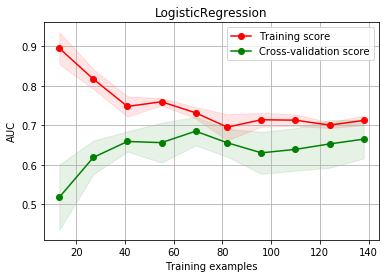

In [94]:
model = LogisticRegression()
plot_learning_curve(model, "LogisticRegression", X_train, Y_train, cv=10)

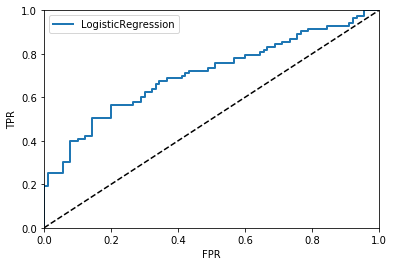

In [95]:
model.fit(X_train, Y_train)
y_train_scores = model.decision_function(X_train)
fpr, tpr, thresholds = roc_curve(Y_train, y_train_scores)
plot_roc_curve([fpr], [tpr], "LogisticRegression", ["LogisticRegression"])

In [96]:
predictions = model.predict(X_test)
y_train_scores = model.decision_function(X_test)
print("Accuracy: ", accuracy_score(targets, predictions))
print("ROC AUC: ", roc_auc_score(targets, y_train_scores))

Accuracy:  0.5681818181818182
ROC AUC:  0.6335403726708074


# May be a more complex model?

In [40]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.utils import np_utils
from keras import regularizers
from keras.optimizers import SGD

kfold = StratifiedKFold(n_splits=10, shuffle=True)
scores = []
for train, test in kfold.split(X_std, Y):
    model = Sequential()
    model.add(Dense(64, input_dim=X_std.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    model.fit(X_std, Y, epochs=1000, batch_size=128)
    score = model.predict_proba(X_test)
    scores.append((roc_auc_score(Y_test, score)))



Epoch 1/1000
217/217 [==============================] - 0s 771us/step - loss: 0.8213 - acc: 0.4839
Epoch 2/1000
217/217 [==============================] - 0s 36us/step - loss: 0.8320 - acc: 0.4194
Epoch 3/1000
217/217 [==============================] - 0s 40us/step - loss: 0.7886 - acc: 0.4286
Epoch 4/1000
217/217 [==============================] - 0s 39us/step - loss: 0.7879 - acc: 0.4793
Epoch 5/1000
217/217 [==============================] - 0s 43us/step - loss: 0.7637 - acc: 0.4793
Epoch 6/1000
217/217 [==============================] - 0s 45us/step - loss: 0.7803 - acc: 0.4700
Epoch 7/1000
217/217 [==============================] - 0s 45us/step - loss: 0.7366 - acc: 0.5023
Epoch 8/1000
217/217 [==============================] - 0s 39us/step - loss: 0.7762 - acc: 0.4516
Epoch 9/1000
217/217 [==============================] - 0s 58us/step - loss: 0.7398 - acc: 0.4516
Epoch 10/1000
217/217 [==============================] - 0s 44us/step - loss: 0.7640 - acc: 0.4654
Epoch 11/1000
217/

217/217 [==============================] - 0s 47us/step - loss: 0.6853 - acc: 0.5300
Epoch 164/1000
217/217 [==============================] - 0s 48us/step - loss: 0.7008 - acc: 0.5530
Epoch 165/1000
217/217 [==============================] - 0s 45us/step - loss: 0.6951 - acc: 0.5253
Epoch 166/1000
217/217 [==============================] - 0s 46us/step - loss: 0.7055 - acc: 0.5622
Epoch 167/1000
217/217 [==============================] - 0s 53us/step - loss: 0.6893 - acc: 0.5899
Epoch 168/1000
217/217 [==============================] - 0s 78us/step - loss: 0.7155 - acc: 0.5115
Epoch 169/1000
217/217 [==============================] - 0s 52us/step - loss: 0.6683 - acc: 0.5806
Epoch 170/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6929 - acc: 0.5484
Epoch 171/1000
217/217 [==============================] - 0s 57us/step - loss: 0.6864 - acc: 0.6083
Epoch 172/1000
217/217 [==============================] - 0s 58us/step - loss: 0.7024 - acc: 0.5438
Epoch 173/1000


217/217 [==============================] - 0s 44us/step - loss: 0.6468 - acc: 0.6359
Epoch 325/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6642 - acc: 0.6267
Epoch 326/1000
217/217 [==============================] - 0s 49us/step - loss: 0.6596 - acc: 0.6175
Epoch 327/1000
217/217 [==============================] - 0s 47us/step - loss: 0.6796 - acc: 0.5806
Epoch 328/1000
217/217 [==============================] - 0s 66us/step - loss: 0.6593 - acc: 0.6406
Epoch 329/1000
217/217 [==============================] - 0s 56us/step - loss: 0.6653 - acc: 0.6498
Epoch 330/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6618 - acc: 0.6037
Epoch 331/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6611 - acc: 0.6037
Epoch 332/1000
217/217 [==============================] - ETA: 0s - loss: 0.6253 - acc: 0.648 - 0s 42us/step - loss: 0.6385 - acc: 0.6037
Epoch 333/1000
217/217 [==============================] - 0s 49us/step - loss

217/217 [==============================] - 0s 35us/step - loss: 0.6427 - acc: 0.6083
Epoch 485/1000
217/217 [==============================] - 0s 50us/step - loss: 0.6526 - acc: 0.5945
Epoch 486/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6360 - acc: 0.6221
Epoch 487/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6488 - acc: 0.6175
Epoch 488/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6729 - acc: 0.6037
Epoch 489/1000
217/217 [==============================] - 0s 51us/step - loss: 0.6555 - acc: 0.6313
Epoch 490/1000
217/217 [==============================] - 0s 46us/step - loss: 0.6530 - acc: 0.6313
Epoch 491/1000
217/217 [==============================] - 0s 58us/step - loss: 0.6757 - acc: 0.5899
Epoch 492/1000
217/217 [==============================] - 0s 46us/step - loss: 0.6365 - acc: 0.6774
Epoch 493/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6427 - acc: 0.6267
Epoch 494/1000


217/217 [==============================] - 0s 35us/step - loss: 0.6607 - acc: 0.6037
Epoch 647/1000
217/217 [==============================] - 0s 46us/step - loss: 0.6383 - acc: 0.6544
Epoch 648/1000
217/217 [==============================] - 0s 49us/step - loss: 0.6488 - acc: 0.6682
Epoch 649/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6515 - acc: 0.6267
Epoch 650/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6671 - acc: 0.5991
Epoch 651/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6567 - acc: 0.6359
Epoch 652/1000
217/217 [==============================] - 0s 47us/step - loss: 0.6212 - acc: 0.6959
Epoch 653/1000
217/217 [==============================] - 0s 29us/step - loss: 0.6741 - acc: 0.6175
Epoch 654/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6538 - acc: 0.6313
Epoch 655/1000
217/217 [==============================] - 0s 48us/step - loss: 0.6436 - acc: 0.6083
Epoch 656/1000


217/217 [==============================] - 0s 45us/step - loss: 0.6120 - acc: 0.7051
Epoch 808/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6170 - acc: 0.6912
Epoch 809/1000
217/217 [==============================] - 0s 47us/step - loss: 0.6324 - acc: 0.6359
Epoch 810/1000
217/217 [==============================] - 0s 52us/step - loss: 0.6274 - acc: 0.6590
Epoch 811/1000
217/217 [==============================] - ETA: 0s - loss: 0.6254 - acc: 0.695 - 0s 68us/step - loss: 0.6297 - acc: 0.6774
Epoch 812/1000
217/217 [==============================] - ETA: 0s - loss: 0.6530 - acc: 0.609 - 0s 43us/step - loss: 0.6372 - acc: 0.6313
Epoch 813/1000
217/217 [==============================] - 0s 45us/step - loss: 0.6346 - acc: 0.6866
Epoch 814/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6288 - acc: 0.6866
Epoch 815/1000
217/217 [==============================] - 0s 45us/step - loss: 0.6302 - acc: 0.6267
Epoch 816/1000
217/217 [===============

217/217 [==============================] - 0s 49us/step - loss: 0.6102 - acc: 0.7005
Epoch 967/1000
217/217 [==============================] - 0s 47us/step - loss: 0.6397 - acc: 0.6498
Epoch 968/1000
217/217 [==============================] - 0s 45us/step - loss: 0.6376 - acc: 0.6359
Epoch 969/1000
217/217 [==============================] - 0s 47us/step - loss: 0.6114 - acc: 0.7005
Epoch 970/1000
217/217 [==============================] - 0s 45us/step - loss: 0.6315 - acc: 0.6682
Epoch 971/1000
217/217 [==============================] - 0s 50us/step - loss: 0.5966 - acc: 0.7051
Epoch 972/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6284 - acc: 0.6544
Epoch 973/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6270 - acc: 0.6452
Epoch 974/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6347 - acc: 0.6682
Epoch 975/1000
217/217 [==============================] - 0s 51us/step - loss: 0.5994 - acc: 0.7143
Epoch 976/1000


217/217 [==============================] - 0s 43us/step - loss: 0.7160 - acc: 0.5760
Epoch 47/1000
217/217 [==============================] - 0s 44us/step - loss: 0.7035 - acc: 0.5484
Epoch 48/1000
217/217 [==============================] - 0s 49us/step - loss: 0.7205 - acc: 0.4654
Epoch 49/1000
217/217 [==============================] - 0s 45us/step - loss: 0.7056 - acc: 0.5622
Epoch 50/1000
217/217 [==============================] - 0s 65us/step - loss: 0.6832 - acc: 0.5853
Epoch 51/1000
217/217 [==============================] - 0s 54us/step - loss: 0.7702 - acc: 0.4839
Epoch 52/1000
217/217 [==============================] - 0s 43us/step - loss: 0.7618 - acc: 0.5161
Epoch 53/1000
217/217 [==============================] - 0s 41us/step - loss: 0.7039 - acc: 0.5023
Epoch 54/1000
217/217 [==============================] - 0s 51us/step - loss: 0.7522 - acc: 0.4747
Epoch 55/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6987 - acc: 0.5253
Epoch 56/1000
217/217 [=

217/217 [==============================] - 0s 52us/step - loss: 0.7034 - acc: 0.5714
Epoch 208/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6743 - acc: 0.5760
Epoch 209/1000
217/217 [==============================] - 0s 35us/step - loss: 0.7090 - acc: 0.5392
Epoch 210/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6722 - acc: 0.6406
Epoch 211/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6677 - acc: 0.5991
Epoch 212/1000
217/217 [==============================] - 0s 46us/step - loss: 0.6795 - acc: 0.5899
Epoch 213/1000
217/217 [==============================] - 0s 51us/step - loss: 0.6800 - acc: 0.5714
Epoch 214/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6940 - acc: 0.5806
Epoch 215/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6748 - acc: 0.5668
Epoch 216/1000
217/217 [==============================] - 0s 56us/step - loss: 0.6682 - acc: 0.5806
Epoch 217/1000


217/217 [==============================] - 0s 44us/step - loss: 0.6765 - acc: 0.5899
Epoch 370/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6910 - acc: 0.5392
Epoch 371/1000
217/217 [==============================] - 0s 58us/step - loss: 0.6878 - acc: 0.6083
Epoch 372/1000
217/217 [==============================] - 0s 53us/step - loss: 0.6625 - acc: 0.6313
Epoch 373/1000
217/217 [==============================] - 0s 58us/step - loss: 0.6609 - acc: 0.6037
Epoch 374/1000
217/217 [==============================] - 0s 46us/step - loss: 0.6852 - acc: 0.5622
Epoch 375/1000
217/217 [==============================] - 0s 32us/step - loss: 0.6661 - acc: 0.5991
Epoch 376/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6678 - acc: 0.6083
Epoch 377/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6993 - acc: 0.5760
Epoch 378/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6411 - acc: 0.6544
Epoch 379/1000


217/217 [==============================] - 0s 39us/step - loss: 0.6385 - acc: 0.6820
Epoch 452/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6747 - acc: 0.5945
Epoch 453/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6378 - acc: 0.6129
Epoch 454/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6512 - acc: 0.6129
Epoch 455/1000
217/217 [==============================] - 0s 54us/step - loss: 0.6671 - acc: 0.6313
Epoch 456/1000
217/217 [==============================] - 0s 65us/step - loss: 0.6602 - acc: 0.6452
Epoch 457/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6640 - acc: 0.6037
Epoch 458/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6983 - acc: 0.5945
Epoch 459/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6554 - acc: 0.6037
Epoch 460/1000
217/217 [==============================] - 0s 61us/step - loss: 0.6657 - acc: 0.6452
Epoch 461/1000


Epoch 614/1000
217/217 [==============================] - 0s 45us/step - loss: 0.6369 - acc: 0.6498
Epoch 615/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6338 - acc: 0.6820
Epoch 616/1000
217/217 [==============================] - 0s 49us/step - loss: 0.6341 - acc: 0.6636
Epoch 617/1000
217/217 [==============================] - 0s 64us/step - loss: 0.6687 - acc: 0.6037
Epoch 618/1000
217/217 [==============================] - 0s 55us/step - loss: 0.6612 - acc: 0.5899
Epoch 619/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6420 - acc: 0.6359
Epoch 620/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6654 - acc: 0.6037
Epoch 621/1000
217/217 [==============================] - 0s 55us/step - loss: 0.6619 - acc: 0.6590
Epoch 622/1000
217/217 [==============================] - 0s 63us/step - loss: 0.6522 - acc: 0.6129
Epoch 623/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6254 - acc: 0.6820


217/217 [==============================] - 0s 52us/step - loss: 0.6536 - acc: 0.6359
Epoch 776/1000
217/217 [==============================] - 0s 50us/step - loss: 0.6541 - acc: 0.6866
Epoch 777/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6535 - acc: 0.6590
Epoch 778/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6629 - acc: 0.6221
Epoch 779/1000
217/217 [==============================] - 0s 58us/step - loss: 0.6334 - acc: 0.6636
Epoch 780/1000
217/217 [==============================] - 0s 70us/step - loss: 0.6376 - acc: 0.6452
Epoch 781/1000
217/217 [==============================] - 0s 69us/step - loss: 0.6375 - acc: 0.6359
Epoch 782/1000
217/217 [==============================] - 0s 53us/step - loss: 0.6360 - acc: 0.6544
Epoch 783/1000
217/217 [==============================] - 0s 49us/step - loss: 0.6176 - acc: 0.6728
Epoch 784/1000
217/217 [==============================] - 0s 48us/step - loss: 0.6381 - acc: 0.6544
Epoch 785/1000


217/217 [==============================] - 0s 47us/step - loss: 0.6580 - acc: 0.6498
Epoch 937/1000
217/217 [==============================] - 0s 55us/step - loss: 0.6158 - acc: 0.6866
Epoch 938/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6428 - acc: 0.6452
Epoch 939/1000
217/217 [==============================] - 0s 51us/step - loss: 0.6714 - acc: 0.6129
Epoch 940/1000
217/217 [==============================] - 0s 52us/step - loss: 0.6328 - acc: 0.6129
Epoch 941/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6267 - acc: 0.7097
Epoch 942/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6118 - acc: 0.6636
Epoch 943/1000
217/217 [==============================] - 0s 46us/step - loss: 0.6186 - acc: 0.6544
Epoch 944/1000
217/217 [==============================] - 0s 51us/step - loss: 0.6209 - acc: 0.7005
Epoch 945/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6286 - acc: 0.6498
Epoch 946/1000


217/217 [==============================] - 0s 44us/step - loss: 0.7167 - acc: 0.4885
Epoch 18/1000
217/217 [==============================] - 0s 51us/step - loss: 0.7287 - acc: 0.5253
Epoch 19/1000
217/217 [==============================] - 0s 45us/step - loss: 0.7118 - acc: 0.5392
Epoch 20/1000
217/217 [==============================] - ETA: 0s - loss: 0.7332 - acc: 0.500 - 0s 40us/step - loss: 0.7188 - acc: 0.5115
Epoch 21/1000
217/217 [==============================] - 0s 58us/step - loss: 0.7067 - acc: 0.5253
Epoch 22/1000
217/217 [==============================] - 0s 49us/step - loss: 0.7327 - acc: 0.5023
Epoch 23/1000
217/217 [==============================] - 0s 65us/step - loss: 0.7040 - acc: 0.5115
Epoch 24/1000
217/217 [==============================] - 0s 49us/step - loss: 0.7200 - acc: 0.5115
Epoch 25/1000
217/217 [==============================] - 0s 50us/step - loss: 0.7115 - acc: 0.5300
Epoch 26/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6915 

217/217 [==============================] - ETA: 0s - loss: 0.6924 - acc: 0.578 - 0s 37us/step - loss: 0.6943 - acc: 0.5622
Epoch 178/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6820 - acc: 0.5622
Epoch 179/1000
217/217 [==============================] - 0s 53us/step - loss: 0.6883 - acc: 0.5760
Epoch 180/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6804 - acc: 0.5760
Epoch 181/1000
217/217 [==============================] - 0s 54us/step - loss: 0.6720 - acc: 0.6129
Epoch 182/1000
217/217 [==============================] - 0s 48us/step - loss: 0.6696 - acc: 0.6037
Epoch 183/1000
217/217 [==============================] - 0s 46us/step - loss: 0.6469 - acc: 0.6590
Epoch 184/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6867 - acc: 0.6083
Epoch 185/1000
217/217 [==============================] - 0s 45us/step - loss: 0.6468 - acc: 0.6083
Epoch 186/1000
217/217 [==============================] - 0s 56us/step - loss

217/217 [==============================] - 0s 44us/step - loss: 0.6576 - acc: 0.6083
Epoch 339/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6444 - acc: 0.6452
Epoch 340/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6546 - acc: 0.6037
Epoch 341/1000
217/217 [==============================] - 0s 48us/step - loss: 0.6289 - acc: 0.6313
Epoch 342/1000
217/217 [==============================] - 0s 68us/step - loss: 0.6626 - acc: 0.6037
Epoch 343/1000
217/217 [==============================] - 0s 50us/step - loss: 0.6394 - acc: 0.6313
Epoch 344/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6312 - acc: 0.6498
Epoch 345/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6472 - acc: 0.6452
Epoch 346/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6756 - acc: 0.5622
Epoch 347/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6301 - acc: 0.6590
Epoch 348/1000


217/217 [==============================] - 0s 46us/step - loss: 0.6445 - acc: 0.6406
Epoch 501/1000
217/217 [==============================] - 0s 47us/step - loss: 0.6368 - acc: 0.5899
Epoch 502/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6697 - acc: 0.6083
Epoch 503/1000
217/217 [==============================] - 0s 47us/step - loss: 0.6380 - acc: 0.6544
Epoch 504/1000
217/217 [==============================] - 0s 55us/step - loss: 0.6490 - acc: 0.6037
Epoch 505/1000
217/217 [==============================] - 0s 61us/step - loss: 0.6463 - acc: 0.6590
Epoch 506/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6240 - acc: 0.6682
Epoch 507/1000
217/217 [==============================] - 0s 50us/step - loss: 0.6619 - acc: 0.6129
Epoch 508/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6220 - acc: 0.6221
Epoch 509/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6534 - acc: 0.6221
Epoch 510/1000


217/217 [==============================] - 0s 33us/step - loss: 0.6344 - acc: 0.6682
Epoch 664/1000
217/217 [==============================] - 0s 49us/step - loss: 0.6306 - acc: 0.6359
Epoch 665/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6190 - acc: 0.6866
Epoch 666/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6423 - acc: 0.6175
Epoch 667/1000
217/217 [==============================] - 0s 45us/step - loss: 0.6554 - acc: 0.6359
Epoch 668/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6415 - acc: 0.6452
Epoch 669/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6433 - acc: 0.6452
Epoch 670/1000
217/217 [==============================] - 0s 46us/step - loss: 0.6304 - acc: 0.6866
Epoch 671/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6270 - acc: 0.6820
Epoch 672/1000
217/217 [==============================] - 0s 47us/step - loss: 0.6275 - acc: 0.6636
Epoch 673/1000


217/217 [==============================] - 0s 44us/step - loss: 0.6375 - acc: 0.6728
Epoch 825/1000
217/217 [==============================] - 0s 46us/step - loss: 0.6376 - acc: 0.6590
Epoch 826/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6437 - acc: 0.6452
Epoch 827/1000
217/217 [==============================] - 0s 53us/step - loss: 0.6236 - acc: 0.6820
Epoch 828/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6094 - acc: 0.6820
Epoch 829/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6193 - acc: 0.6866
Epoch 830/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6202 - acc: 0.6498
Epoch 831/1000
217/217 [==============================] - 0s 47us/step - loss: 0.6386 - acc: 0.6498
Epoch 832/1000
217/217 [==============================] - 0s 48us/step - loss: 0.6140 - acc: 0.6682
Epoch 833/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6256 - acc: 0.6406
Epoch 834/1000


217/217 [==============================] - 0s 58us/step - loss: 0.6113 - acc: 0.6774
Epoch 985/1000
217/217 [==============================] - 0s 53us/step - loss: 0.6310 - acc: 0.6682
Epoch 986/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6409 - acc: 0.6452
Epoch 987/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6312 - acc: 0.6912
Epoch 988/1000
217/217 [==============================] - 0s 45us/step - loss: 0.6499 - acc: 0.6498
Epoch 989/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6229 - acc: 0.6682
Epoch 990/1000
217/217 [==============================] - 0s 45us/step - loss: 0.5976 - acc: 0.6774
Epoch 991/1000
217/217 [==============================] - 0s 48us/step - loss: 0.6179 - acc: 0.6774
Epoch 992/1000
217/217 [==============================] - 0s 49us/step - loss: 0.6300 - acc: 0.6498
Epoch 993/1000
217/217 [==============================] - 0s 52us/step - loss: 0.6346 - acc: 0.6728
Epoch 994/1000


217/217 [==============================] - 0s 54us/step - loss: 0.7004 - acc: 0.5346
Epoch 147/1000
217/217 [==============================] - 0s 48us/step - loss: 0.6835 - acc: 0.5668
Epoch 148/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6653 - acc: 0.6406
Epoch 149/1000
217/217 [==============================] - 0s 54us/step - loss: 0.7075 - acc: 0.5484
Epoch 150/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6788 - acc: 0.5668
Epoch 151/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6734 - acc: 0.5438
Epoch 152/1000
217/217 [==============================] - 0s 57us/step - loss: 0.6718 - acc: 0.5945
Epoch 153/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6839 - acc: 0.5714
Epoch 154/1000
217/217 [==============================] - 0s 63us/step - loss: 0.6959 - acc: 0.5438
Epoch 155/1000
217/217 [==============================] - 0s 53us/step - loss: 0.6693 - acc: 0.6083
Epoch 156/1000


217/217 [==============================] - 0s 51us/step - loss: 0.6562 - acc: 0.6175
Epoch 308/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6521 - acc: 0.6452
Epoch 309/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6564 - acc: 0.6267
Epoch 310/1000
217/217 [==============================] - 0s 49us/step - loss: 0.6958 - acc: 0.5760
Epoch 311/1000
217/217 [==============================] - 0s 32us/step - loss: 0.6796 - acc: 0.6083
Epoch 312/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6507 - acc: 0.6313
Epoch 313/1000
217/217 [==============================] - 0s 47us/step - loss: 0.6655 - acc: 0.6175
Epoch 314/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6826 - acc: 0.5991
Epoch 315/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6746 - acc: 0.6175
Epoch 316/1000
217/217 [==============================] - 0s 54us/step - loss: 0.6847 - acc: 0.5899
Epoch 317/1000


217/217 [==============================] - 0s 50us/step - loss: 0.6501 - acc: 0.6406
Epoch 469/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6522 - acc: 0.6498
Epoch 470/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6225 - acc: 0.6590
Epoch 471/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6301 - acc: 0.6498
Epoch 472/1000
217/217 [==============================] - 0s 54us/step - loss: 0.6533 - acc: 0.6267
Epoch 473/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6455 - acc: 0.6406
Epoch 474/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6654 - acc: 0.6406
Epoch 475/1000
217/217 [==============================] - 0s 52us/step - loss: 0.6360 - acc: 0.6359
Epoch 476/1000
217/217 [==============================] - 0s 45us/step - loss: 0.6339 - acc: 0.6728
Epoch 477/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6467 - acc: 0.6406
Epoch 478/1000


217/217 [==============================] - 0s 41us/step - loss: 0.6315 - acc: 0.6590
Epoch 629/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6724 - acc: 0.6129
Epoch 630/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6299 - acc: 0.6267
Epoch 631/1000
217/217 [==============================] - 0s 46us/step - loss: 0.6078 - acc: 0.7005
Epoch 632/1000
217/217 [==============================] - 0s 59us/step - loss: 0.6576 - acc: 0.5945
Epoch 633/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6327 - acc: 0.6313
Epoch 634/1000
217/217 [==============================] - 0s 64us/step - loss: 0.6559 - acc: 0.6313
Epoch 635/1000
217/217 [==============================] - 0s 74us/step - loss: 0.6431 - acc: 0.6590
Epoch 636/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6553 - acc: 0.6313
Epoch 637/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6699 - acc: 0.6267
Epoch 638/1000


217/217 [==============================] - 0s 37us/step - loss: 0.6053 - acc: 0.6820
Epoch 790/1000
217/217 [==============================] - 0s 32us/step - loss: 0.6555 - acc: 0.6313
Epoch 791/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6304 - acc: 0.6452
Epoch 792/1000
217/217 [==============================] - ETA: 0s - loss: 0.5980 - acc: 0.671 - 0s 60us/step - loss: 0.6170 - acc: 0.6590
Epoch 793/1000
217/217 [==============================] - 0s 49us/step - loss: 0.6076 - acc: 0.6728
Epoch 794/1000
217/217 [==============================] - ETA: 0s - loss: 0.6297 - acc: 0.664 - 0s 35us/step - loss: 0.6385 - acc: 0.6359
Epoch 795/1000
217/217 [==============================] - 0s 69us/step - loss: 0.5969 - acc: 0.7051
Epoch 796/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6347 - acc: 0.6498
Epoch 797/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6282 - acc: 0.6498
Epoch 798/1000
217/217 [===============

217/217 [==============================] - 0s 36us/step - loss: 0.6054 - acc: 0.6590
Epoch 950/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6332 - acc: 0.6129
Epoch 951/1000
217/217 [==============================] - 0s 47us/step - loss: 0.6354 - acc: 0.6498
Epoch 952/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6557 - acc: 0.6774
Epoch 953/1000
217/217 [==============================] - 0s 46us/step - loss: 0.6502 - acc: 0.6452
Epoch 954/1000
217/217 [==============================] - 0s 57us/step - loss: 0.6111 - acc: 0.6636
Epoch 955/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6054 - acc: 0.6774
Epoch 956/1000
217/217 [==============================] - 0s 79us/step - loss: 0.6020 - acc: 0.6959
Epoch 957/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6398 - acc: 0.6359
Epoch 958/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6174 - acc: 0.6682
Epoch 959/1000


217/217 [==============================] - 0s 42us/step - loss: 0.6996 - acc: 0.5668
Epoch 113/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6933 - acc: 0.5622
Epoch 114/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6975 - acc: 0.5253
Epoch 115/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6751 - acc: 0.5668
Epoch 116/1000
217/217 [==============================] - 0s 39us/step - loss: 0.7319 - acc: 0.5438
Epoch 117/1000
217/217 [==============================] - 0s 40us/step - loss: 0.7074 - acc: 0.5853
Epoch 118/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6990 - acc: 0.5207
Epoch 119/1000
217/217 [==============================] - 0s 41us/step - loss: 0.7079 - acc: 0.5484
Epoch 120/1000
217/217 [==============================] - 0s 37us/step - loss: 0.7135 - acc: 0.5161
Epoch 121/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6736 - acc: 0.5760
Epoch 122/1000


217/217 [==============================] - 0s 34us/step - loss: 0.6454 - acc: 0.5945
Epoch 274/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6627 - acc: 0.5899
Epoch 275/1000
217/217 [==============================] - 0s 27us/step - loss: 0.6618 - acc: 0.6175
Epoch 276/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6580 - acc: 0.6498
Epoch 277/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6508 - acc: 0.6452
Epoch 278/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6931 - acc: 0.5253
Epoch 279/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6532 - acc: 0.6267
Epoch 280/1000
217/217 [==============================] - 0s 29us/step - loss: 0.6509 - acc: 0.6544
Epoch 281/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6531 - acc: 0.6129
Epoch 282/1000
217/217 [==============================] - 0s 28us/step - loss: 0.6563 - acc: 0.6129
Epoch 283/1000


/Users/kamranhaider/anaconda3/envs/demo/lib/python3.5/site-packages/keras/callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116085). Check your callbacks.
  % delta_t_median)


Epoch 386/1000
217/217 [==============================] - 0s 90us/step - loss: 0.6598 - acc: 0.6313
Epoch 387/1000
217/217 [==============================] - 0s 61us/step - loss: 0.6763 - acc: 0.5760
Epoch 388/1000
217/217 [==============================] - 0s 60us/step - loss: 0.6438 - acc: 0.6406
Epoch 389/1000
217/217 [==============================] - 0s 62us/step - loss: 0.6417 - acc: 0.6590
Epoch 390/1000
217/217 [==============================] - 0s 45us/step - loss: 0.6751 - acc: 0.6037
Epoch 391/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6588 - acc: 0.5899
Epoch 392/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6392 - acc: 0.6221
Epoch 393/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6975 - acc: 0.5576
Epoch 394/1000
217/217 [==============================] - ETA: 0s - loss: 0.6588 - acc: 0.679 - 0s 68us/step - loss: 0.6483 - acc: 0.6544
Epoch 395/1000
217/217 [==============================] - 0s 6

217/217 [==============================] - 0s 37us/step - loss: 0.6348 - acc: 0.6498
Epoch 467/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6582 - acc: 0.6083
Epoch 468/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6463 - acc: 0.5991
Epoch 469/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6633 - acc: 0.6083
Epoch 470/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6420 - acc: 0.6083
Epoch 471/1000
217/217 [==============================] - 0s 32us/step - loss: 0.6488 - acc: 0.6267
Epoch 472/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6681 - acc: 0.5853
Epoch 473/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6493 - acc: 0.6406
Epoch 474/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6209 - acc: 0.6406
Epoch 475/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6401 - acc: 0.6313
Epoch 476/1000


217/217 [==============================] - 0s 42us/step - loss: 0.6489 - acc: 0.6037
Epoch 629/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6588 - acc: 0.6498
Epoch 630/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6495 - acc: 0.6175
Epoch 631/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6345 - acc: 0.6544
Epoch 632/1000
217/217 [==============================] - 0s 32us/step - loss: 0.6567 - acc: 0.6313
Epoch 633/1000
217/217 [==============================] - 0s 28us/step - loss: 0.6735 - acc: 0.6083
Epoch 634/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6513 - acc: 0.6129
Epoch 635/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6622 - acc: 0.6175
Epoch 636/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6517 - acc: 0.6083
Epoch 637/1000
217/217 [==============================] - 0s 31us/step - loss: 0.6042 - acc: 0.6774
Epoch 638/1000


217/217 [==============================] - 0s 38us/step - loss: 0.6258 - acc: 0.6682
Epoch 791/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6347 - acc: 0.6590
Epoch 792/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6440 - acc: 0.6544
Epoch 793/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6301 - acc: 0.6774
Epoch 794/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6557 - acc: 0.6129
Epoch 795/1000
217/217 [==============================] - 0s 36us/step - loss: 0.5874 - acc: 0.6728
Epoch 796/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6418 - acc: 0.6544
Epoch 797/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6358 - acc: 0.6175
Epoch 798/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6157 - acc: 0.6682
Epoch 799/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6620 - acc: 0.6590
Epoch 800/1000


217/217 [==============================] - 0s 37us/step - loss: 0.6184 - acc: 0.6728
Epoch 952/1000
217/217 [==============================] - 0s 69us/step - loss: 0.6398 - acc: 0.6359
Epoch 953/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6370 - acc: 0.6820
Epoch 954/1000
217/217 [==============================] - 0s 94us/step - loss: 0.6233 - acc: 0.6636
Epoch 955/1000
217/217 [==============================] - 0s 66us/step - loss: 0.6407 - acc: 0.6267
Epoch 956/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6274 - acc: 0.6313
Epoch 957/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6115 - acc: 0.6774
Epoch 958/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6240 - acc: 0.6590
Epoch 959/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6336 - acc: 0.6313
Epoch 960/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6081 - acc: 0.6774
Epoch 961/1000


217/217 [==============================] - 0s 38us/step - loss: 0.6702 - acc: 0.6037
Epoch 114/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6845 - acc: 0.5899
Epoch 115/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6686 - acc: 0.5622
Epoch 116/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6929 - acc: 0.5622
Epoch 117/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6876 - acc: 0.5576
Epoch 118/1000
217/217 [==============================] - 0s 55us/step - loss: 0.7150 - acc: 0.5438
Epoch 119/1000
217/217 [==============================] - 0s 37us/step - loss: 0.7002 - acc: 0.5484
Epoch 120/1000
217/217 [==============================] - 0s 95us/step - loss: 0.6936 - acc: 0.5530
Epoch 121/1000
217/217 [==============================] - 0s 53us/step - loss: 0.6742 - acc: 0.6175
Epoch 122/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6619 - acc: 0.5945
Epoch 123/1000


217/217 [==============================] - 0s 36us/step - loss: 0.6586 - acc: 0.6129
Epoch 275/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6492 - acc: 0.6267
Epoch 276/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6825 - acc: 0.6083
Epoch 277/1000
217/217 [==============================] - 0s 101us/step - loss: 0.6460 - acc: 0.6175
Epoch 278/1000
217/217 [==============================] - 0s 55us/step - loss: 0.6819 - acc: 0.5484
Epoch 279/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6569 - acc: 0.6590
Epoch 280/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6580 - acc: 0.6498
Epoch 281/1000
217/217 [==============================] - 0s 50us/step - loss: 0.6487 - acc: 0.6267
Epoch 282/1000
217/217 [==============================] - 0s 49us/step - loss: 0.6915 - acc: 0.5991
Epoch 283/1000
217/217 [==============================] - 0s 47us/step - loss: 0.6808 - acc: 0.5760
Epoch 284/1000

217/217 [==============================] - 0s 55us/step - loss: 0.6576 - acc: 0.6083
Epoch 435/1000
217/217 [==============================] - 0s 52us/step - loss: 0.6475 - acc: 0.6452
Epoch 436/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6481 - acc: 0.6267
Epoch 437/1000
217/217 [==============================] - 0s 48us/step - loss: 0.6558 - acc: 0.6313
Epoch 438/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6586 - acc: 0.6313
Epoch 439/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6673 - acc: 0.6221
Epoch 440/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6255 - acc: 0.6590
Epoch 441/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6550 - acc: 0.6083
Epoch 442/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6502 - acc: 0.5899
Epoch 443/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6158 - acc: 0.6590
Epoch 444/1000


217/217 [==============================] - 0s 39us/step - loss: 0.6234 - acc: 0.6866
Epoch 596/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6144 - acc: 0.6636
Epoch 597/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6206 - acc: 0.6774
Epoch 598/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6613 - acc: 0.6359
Epoch 599/1000
217/217 [==============================] - 0s 45us/step - loss: 0.6509 - acc: 0.6267
Epoch 600/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6512 - acc: 0.6544
Epoch 601/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6579 - acc: 0.6590
Epoch 602/1000
217/217 [==============================] - ETA: 0s - loss: 0.6525 - acc: 0.656 - 0s 40us/step - loss: 0.6679 - acc: 0.6590
Epoch 603/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6391 - acc: 0.6682
Epoch 604/1000
217/217 [==============================] - 0s 41us/step - loss

217/217 [==============================] - 0s 34us/step - loss: 0.6593 - acc: 0.6498
Epoch 758/1000
217/217 [==============================] - 0s 31us/step - loss: 0.6473 - acc: 0.6498
Epoch 759/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6352 - acc: 0.6267
Epoch 760/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6189 - acc: 0.6590
Epoch 761/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6341 - acc: 0.6820
Epoch 762/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6262 - acc: 0.6682
Epoch 763/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6189 - acc: 0.6359
Epoch 764/1000
217/217 [==============================] - 0s 31us/step - loss: 0.6260 - acc: 0.6544
Epoch 765/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6219 - acc: 0.6590
Epoch 766/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6329 - acc: 0.6820
Epoch 767/1000


217/217 [==============================] - 0s 42us/step - loss: 0.6228 - acc: 0.6590
Epoch 918/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6124 - acc: 0.6682
Epoch 919/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6242 - acc: 0.6590
Epoch 920/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6255 - acc: 0.6590
Epoch 921/1000
217/217 [==============================] - 0s 31us/step - loss: 0.6026 - acc: 0.6728
Epoch 922/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6324 - acc: 0.6452
Epoch 923/1000
217/217 [==============================] - 0s 31us/step - loss: 0.6146 - acc: 0.6866
Epoch 924/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6024 - acc: 0.6544
Epoch 925/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6068 - acc: 0.6728
Epoch 926/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6077 - acc: 0.6866
Epoch 927/1000


217/217 [==============================] - 0s 36us/step - loss: 0.7182 - acc: 0.5207
Epoch 79/1000
217/217 [==============================] - 0s 38us/step - loss: 0.7096 - acc: 0.4839
Epoch 80/1000
217/217 [==============================] - ETA: 0s - loss: 0.7194 - acc: 0.492 - 0s 42us/step - loss: 0.7152 - acc: 0.5115
Epoch 81/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6956 - acc: 0.5760
Epoch 82/1000
217/217 [==============================] - 0s 40us/step - loss: 0.7422 - acc: 0.4747
Epoch 83/1000
217/217 [==============================] - 0s 39us/step - loss: 0.7015 - acc: 0.5576
Epoch 84/1000
217/217 [==============================] - 0s 39us/step - loss: 0.7016 - acc: 0.5899
Epoch 85/1000
217/217 [==============================] - 0s 35us/step - loss: 0.7209 - acc: 0.5115
Epoch 86/1000
217/217 [==============================] - 0s 39us/step - loss: 0.7232 - acc: 0.4977
Epoch 87/1000
217/217 [==============================] - 0s 39us/step - loss: 0.7251 

217/217 [==============================] - 0s 32us/step - loss: 0.6778 - acc: 0.5484
Epoch 160/1000
217/217 [==============================] - ETA: 0s - loss: 0.6958 - acc: 0.546 - 0s 30us/step - loss: 0.6995 - acc: 0.5346
Epoch 161/1000
217/217 [==============================] - 0s 32us/step - loss: 0.6859 - acc: 0.5760
Epoch 162/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6459 - acc: 0.6313
Epoch 163/1000
217/217 [==============================] - 0s 30us/step - loss: 0.6786 - acc: 0.5806
Epoch 164/1000
217/217 [==============================] - 0s 31us/step - loss: 0.6803 - acc: 0.5853
Epoch 165/1000
217/217 [==============================] - 0s 32us/step - loss: 0.7004 - acc: 0.5714
Epoch 166/1000
217/217 [==============================] - 0s 29us/step - loss: 0.6803 - acc: 0.6313
Epoch 167/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6963 - acc: 0.5300
Epoch 168/1000
217/217 [==============================] - ETA: 0s - loss: 0.6

217/217 [==============================] - 0s 41us/step - loss: 0.6686 - acc: 0.5991
Epoch 317/1000
217/217 [==============================] - 0s 59us/step - loss: 0.6838 - acc: 0.5576
Epoch 318/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6742 - acc: 0.5760
Epoch 319/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6693 - acc: 0.6037
Epoch 320/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6631 - acc: 0.5668
Epoch 321/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6595 - acc: 0.5991
Epoch 322/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6494 - acc: 0.5945
Epoch 323/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6511 - acc: 0.5991
Epoch 324/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6670 - acc: 0.6313
Epoch 325/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6396 - acc: 0.6452
Epoch 326/1000


217/217 [==============================] - 0s 37us/step - loss: 0.6222 - acc: 0.6359
Epoch 399/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6462 - acc: 0.6313
Epoch 400/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6704 - acc: 0.6175
Epoch 401/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6546 - acc: 0.6221
Epoch 402/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6292 - acc: 0.6452
Epoch 403/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6503 - acc: 0.6359
Epoch 404/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6840 - acc: 0.5714
Epoch 405/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6416 - acc: 0.6083
Epoch 406/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6538 - acc: 0.6406
Epoch 407/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6496 - acc: 0.6129
Epoch 408/1000


217/217 [==============================] - 0s 38us/step - loss: 0.6463 - acc: 0.6313
Epoch 559/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6322 - acc: 0.6359
Epoch 560/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6691 - acc: 0.6221
Epoch 561/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6420 - acc: 0.6682
Epoch 562/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6663 - acc: 0.5622
Epoch 563/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6382 - acc: 0.6636
Epoch 564/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6381 - acc: 0.6590
Epoch 565/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6356 - acc: 0.6406
Epoch 566/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6375 - acc: 0.6221
Epoch 567/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6404 - acc: 0.6267
Epoch 568/1000


217/217 [==============================] - 0s 38us/step - loss: 0.6185 - acc: 0.6590
Epoch 721/1000
217/217 [==============================] - 0s 30us/step - loss: 0.6364 - acc: 0.6682
Epoch 722/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6231 - acc: 0.6636
Epoch 723/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6547 - acc: 0.6498
Epoch 724/1000
217/217 [==============================] - 0s 31us/step - loss: 0.6304 - acc: 0.6498
Epoch 725/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6146 - acc: 0.6682
Epoch 726/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6324 - acc: 0.6636
Epoch 727/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6140 - acc: 0.6590
Epoch 728/1000
217/217 [==============================] - 0s 59us/step - loss: 0.6572 - acc: 0.6498
Epoch 729/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6255 - acc: 0.7005
Epoch 730/1000


217/217 [==============================] - 0s 53us/step - loss: 0.6281 - acc: 0.6636
Epoch 882/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6120 - acc: 0.7097
Epoch 883/1000
217/217 [==============================] - 0s 47us/step - loss: 0.6352 - acc: 0.6544
Epoch 884/1000
217/217 [==============================] - ETA: 0s - loss: 0.6226 - acc: 0.617 - 0s 103us/step - loss: 0.6227 - acc: 0.6359
Epoch 885/1000
217/217 [==============================] - 0s 71us/step - loss: 0.6291 - acc: 0.6728
Epoch 886/1000
217/217 [==============================] - 0s 130us/step - loss: 0.6149 - acc: 0.6590
Epoch 887/1000
217/217 [==============================] - 0s 73us/step - loss: 0.6214 - acc: 0.6636
Epoch 888/1000
217/217 [==============================] - 0s 44us/step - loss: 0.6084 - acc: 0.6636
Epoch 889/1000
217/217 [==============================] - 0s 55us/step - loss: 0.6213 - acc: 0.6728
Epoch 890/1000
217/217 [==============================] - 0s 47us/step - lo

217/217 [==============================] - 0s 64us/step - loss: 0.7446 - acc: 0.4654
Epoch 44/1000
217/217 [==============================] - 0s 93us/step - loss: 0.7241 - acc: 0.5300
Epoch 45/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6986 - acc: 0.5346
Epoch 46/1000
217/217 [==============================] - 0s 42us/step - loss: 0.7198 - acc: 0.4793
Epoch 47/1000
217/217 [==============================] - 0s 45us/step - loss: 0.7087 - acc: 0.5207
Epoch 48/1000
217/217 [==============================] - 0s 102us/step - loss: 0.7263 - acc: 0.4885
Epoch 49/1000
217/217 [==============================] - 0s 75us/step - loss: 0.7132 - acc: 0.5668
Epoch 50/1000
217/217 [==============================] - 0s 125us/step - loss: 0.7056 - acc: 0.4885
Epoch 51/1000
217/217 [==============================] - 0s 142us/step - loss: 0.7394 - acc: 0.5300
Epoch 52/1000
217/217 [==============================] - 0s 90us/step - loss: 0.7142 - acc: 0.5023
Epoch 53/1000
217/217

Epoch 205/1000
217/217 [==============================] - 0s 54us/step - loss: 0.6972 - acc: 0.5806
Epoch 206/1000
217/217 [==============================] - 0s 51us/step - loss: 0.6565 - acc: 0.6544
Epoch 207/1000
217/217 [==============================] - 0s 53us/step - loss: 0.6755 - acc: 0.5899
Epoch 208/1000
217/217 [==============================] - 0s 104us/step - loss: 0.6609 - acc: 0.6037
Epoch 209/1000
217/217 [==============================] - 0s 82us/step - loss: 0.6897 - acc: 0.5945
Epoch 210/1000
217/217 [==============================] - 0s 67us/step - loss: 0.6659 - acc: 0.6452
Epoch 211/1000
217/217 [==============================] - 0s 86us/step - loss: 0.6809 - acc: 0.5945
Epoch 212/1000
217/217 [==============================] - 0s 106us/step - loss: 0.6762 - acc: 0.6037
Epoch 213/1000
217/217 [==============================] - 0s 98us/step - loss: 0.6773 - acc: 0.5760
Epoch 214/1000
217/217 [==============================] - 0s 53us/step - loss: 0.6931 - acc: 0.562

217/217 [==============================] - 0s 47us/step - loss: 0.6633 - acc: 0.6406
Epoch 366/1000
217/217 [==============================] - 0s 54us/step - loss: 0.6495 - acc: 0.6498
Epoch 367/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6658 - acc: 0.6083
Epoch 368/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6480 - acc: 0.6129
Epoch 369/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6522 - acc: 0.6406
Epoch 370/1000
217/217 [==============================] - 0s 46us/step - loss: 0.6576 - acc: 0.6452
Epoch 371/1000
217/217 [==============================] - 0s 48us/step - loss: 0.6487 - acc: 0.6221
Epoch 372/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6608 - acc: 0.6129
Epoch 373/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6643 - acc: 0.6406
Epoch 374/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6458 - acc: 0.6498
Epoch 375/1000


217/217 [==============================] - 0s 40us/step - loss: 0.6314 - acc: 0.6313
Epoch 528/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6336 - acc: 0.6452
Epoch 529/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6616 - acc: 0.5853
Epoch 530/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6330 - acc: 0.6129
Epoch 531/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6516 - acc: 0.6452
Epoch 532/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6550 - acc: 0.6313
Epoch 533/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6526 - acc: 0.6267
Epoch 534/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6261 - acc: 0.6590
Epoch 535/1000
217/217 [==============================] - ETA: 0s - loss: 0.6430 - acc: 0.671 - 0s 33us/step - loss: 0.6273 - acc: 0.6728
Epoch 536/1000
217/217 [==============================] - 0s 39us/step - loss

217/217 [==============================] - 0s 37us/step - loss: 0.6355 - acc: 0.6498
Epoch 688/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6261 - acc: 0.6959
Epoch 689/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6218 - acc: 0.6728
Epoch 690/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6436 - acc: 0.6544
Epoch 691/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6282 - acc: 0.6590
Epoch 692/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6350 - acc: 0.6452
Epoch 693/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6240 - acc: 0.6820
Epoch 694/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6324 - acc: 0.6129
Epoch 695/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6457 - acc: 0.6452
Epoch 696/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6610 - acc: 0.6313
Epoch 697/1000


217/217 [==============================] - 0s 36us/step - loss: 0.6072 - acc: 0.6682
Epoch 847/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6280 - acc: 0.6774
Epoch 848/1000
217/217 [==============================] - ETA: 0s - loss: 0.6403 - acc: 0.632 - 0s 42us/step - loss: 0.6463 - acc: 0.6452
Epoch 849/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6101 - acc: 0.6544
Epoch 850/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6450 - acc: 0.6452
Epoch 851/1000
217/217 [==============================] - 0s 30us/step - loss: 0.6202 - acc: 0.6912
Epoch 852/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6151 - acc: 0.6590
Epoch 853/1000
217/217 [==============================] - 0s 30us/step - loss: 0.6063 - acc: 0.6959
Epoch 854/1000
217/217 [==============================] - 0s 30us/step - loss: 0.6280 - acc: 0.6544
Epoch 855/1000
217/217 [==============================] - 0s 35us/step - loss

217/217 [==============================] - 0s 36us/step - loss: 0.7700 - acc: 0.4885
Epoch 8/1000
217/217 [==============================] - 0s 36us/step - loss: 0.7537 - acc: 0.5023
Epoch 9/1000
217/217 [==============================] - 0s 31us/step - loss: 0.7730 - acc: 0.4793
Epoch 10/1000
217/217 [==============================] - 0s 34us/step - loss: 0.7378 - acc: 0.5346
Epoch 11/1000
217/217 [==============================] - 0s 35us/step - loss: 0.7817 - acc: 0.5115
Epoch 12/1000
217/217 [==============================] - 0s 36us/step - loss: 0.7510 - acc: 0.4977
Epoch 13/1000
217/217 [==============================] - 0s 35us/step - loss: 0.7360 - acc: 0.5484
Epoch 14/1000
217/217 [==============================] - 0s 36us/step - loss: 0.7359 - acc: 0.4885
Epoch 15/1000
217/217 [==============================] - 0s 37us/step - loss: 0.7523 - acc: 0.5161
Epoch 16/1000
217/217 [==============================] - 0s 33us/step - loss: 0.7366 - acc: 0.5300
Epoch 17/1000
217/217 [===

217/217 [==============================] - 0s 81us/step - loss: 0.6761 - acc: 0.5530
Epoch 169/1000
217/217 [==============================] - ETA: 0s - loss: 0.7282 - acc: 0.546 - 0s 66us/step - loss: 0.7008 - acc: 0.5484
Epoch 170/1000
217/217 [==============================] - 0s 77us/step - loss: 0.6650 - acc: 0.6313
Epoch 171/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6826 - acc: 0.5714
Epoch 172/1000
217/217 [==============================] - 0s 45us/step - loss: 0.6649 - acc: 0.5899
Epoch 173/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6850 - acc: 0.5945
Epoch 174/1000
217/217 [==============================] - 0s 75us/step - loss: 0.6546 - acc: 0.5760
Epoch 175/1000
217/217 [==============================] - 0s 96us/step - loss: 0.7007 - acc: 0.5622
Epoch 176/1000
217/217 [==============================] - 0s 98us/step - loss: 0.7050 - acc: 0.5714
Epoch 177/1000
217/217 [==============================] - 0s 78us/step - loss

217/217 [==============================] - 0s 108us/step - loss: 0.6675 - acc: 0.6221
Epoch 330/1000
217/217 [==============================] - 0s 81us/step - loss: 0.6753 - acc: 0.6221
Epoch 331/1000
217/217 [==============================] - 0s 91us/step - loss: 0.6790 - acc: 0.6037
Epoch 332/1000
217/217 [==============================] - 0s 208us/step - loss: 0.6615 - acc: 0.5853
Epoch 333/1000
217/217 [==============================] - 0s 51us/step - loss: 0.6644 - acc: 0.6267
Epoch 334/1000
217/217 [==============================] - 0s 45us/step - loss: 0.6696 - acc: 0.5945
Epoch 335/1000
217/217 [==============================] - 0s 47us/step - loss: 0.6738 - acc: 0.5622
Epoch 336/1000
217/217 [==============================] - ETA: 0s - loss: 0.6653 - acc: 0.546 - 0s 56us/step - loss: 0.6698 - acc: 0.5576
Epoch 337/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6627 - acc: 0.6037
Epoch 338/1000
217/217 [==============================] - 0s 64us/step - lo

Epoch 408/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6429 - acc: 0.6359
Epoch 409/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6635 - acc: 0.5991
Epoch 410/1000
217/217 [==============================] - ETA: 0s - loss: 0.6739 - acc: 0.546 - 0s 52us/step - loss: 0.6588 - acc: 0.5899
Epoch 411/1000
217/217 [==============================] - 0s 97us/step - loss: 0.6898 - acc: 0.5622
Epoch 412/1000
217/217 [==============================] - 0s 57us/step - loss: 0.6636 - acc: 0.6175
Epoch 413/1000
217/217 [==============================] - 0s 70us/step - loss: 0.6659 - acc: 0.6267
Epoch 414/1000
217/217 [==============================] - 0s 89us/step - loss: 0.6471 - acc: 0.6129
Epoch 415/1000
217/217 [==============================] - 0s 99us/step - loss: 0.6685 - acc: 0.5668
Epoch 416/1000
217/217 [==============================] - 0s 82us/step - loss: 0.6669 - acc: 0.5760
Epoch 417/1000
217/217 [==============================] - 0s 6

217/217 [==============================] - 0s 33us/step - loss: 0.6572 - acc: 0.6175
Epoch 570/1000
217/217 [==============================] - 0s 95us/step - loss: 0.6418 - acc: 0.6267
Epoch 571/1000
217/217 [==============================] - 0s 67us/step - loss: 0.6604 - acc: 0.5576
Epoch 572/1000
217/217 [==============================] - ETA: 0s - loss: 0.6421 - acc: 0.625 - 0s 81us/step - loss: 0.6421 - acc: 0.6175
Epoch 573/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6423 - acc: 0.6406
Epoch 574/1000
217/217 [==============================] - 0s 57us/step - loss: 0.6506 - acc: 0.6221
Epoch 575/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6662 - acc: 0.6267
Epoch 576/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6453 - acc: 0.6221
Epoch 577/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6515 - acc: 0.6129
Epoch 578/1000
217/217 [==============================] - 0s 37us/step - loss

217/217 [==============================] - 0s 26us/step - loss: 0.6515 - acc: 0.5806
Epoch 731/1000
217/217 [==============================] - 0s 30us/step - loss: 0.6785 - acc: 0.5899
Epoch 732/1000
217/217 [==============================] - ETA: 0s - loss: 0.6592 - acc: 0.617 - 0s 27us/step - loss: 0.6575 - acc: 0.5899
Epoch 733/1000
217/217 [==============================] - 0s 45us/step - loss: 0.6755 - acc: 0.5991
Epoch 734/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6462 - acc: 0.6037
Epoch 735/1000
217/217 [==============================] - 0s 28us/step - loss: 0.6394 - acc: 0.6590
Epoch 736/1000
217/217 [==============================] - 0s 27us/step - loss: 0.6456 - acc: 0.6267
Epoch 737/1000
217/217 [==============================] - 0s 26us/step - loss: 0.6276 - acc: 0.6636
Epoch 738/1000
217/217 [==============================] - 0s 30us/step - loss: 0.6686 - acc: 0.6129
Epoch 739/1000
217/217 [==============================] - 0s 39us/step - loss

217/217 [==============================] - 0s 61us/step - loss: 0.6545 - acc: 0.6037
Epoch 891/1000
217/217 [==============================] - 0s 47us/step - loss: 0.6355 - acc: 0.6636
Epoch 892/1000
217/217 [==============================] - ETA: 0s - loss: 0.6378 - acc: 0.648 - 0s 49us/step - loss: 0.6192 - acc: 0.6728
Epoch 893/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6355 - acc: 0.6636
Epoch 894/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6223 - acc: 0.6912
Epoch 895/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6463 - acc: 0.6452
Epoch 896/1000
217/217 [==============================] - 0s 76us/step - loss: 0.6067 - acc: 0.6452
Epoch 897/1000
217/217 [==============================] - 0s 101us/step - loss: 0.6530 - acc: 0.6406
Epoch 898/1000
217/217 [==============================] - 0s 106us/step - loss: 0.6430 - acc: 0.6129
Epoch 899/1000
217/217 [==============================] - 0s 73us/step - lo

217/217 [==============================] - 0s 47us/step - loss: 0.6129 - acc: 0.6728
Epoch 971/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6254 - acc: 0.6774
Epoch 972/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6143 - acc: 0.6866
Epoch 973/1000
217/217 [==============================] - 0s 52us/step - loss: 0.6159 - acc: 0.6452
Epoch 974/1000
217/217 [==============================] - 0s 114us/step - loss: 0.6257 - acc: 0.7005
Epoch 975/1000
217/217 [==============================] - 0s 71us/step - loss: 0.6132 - acc: 0.6498
Epoch 976/1000
217/217 [==============================] - 0s 79us/step - loss: 0.6478 - acc: 0.6129
Epoch 977/1000
217/217 [==============================] - 0s 103us/step - loss: 0.6200 - acc: 0.6359
Epoch 978/1000
217/217 [==============================] - 0s 81us/step - loss: 0.6345 - acc: 0.6590
Epoch 979/1000
217/217 [==============================] - 0s 78us/step - loss: 0.6412 - acc: 0.6590
Epoch 980/100

217/217 [==============================] - 0s 56us/step - loss: 0.7095 - acc: 0.5346
Epoch 53/1000
217/217 [==============================] - 0s 105us/step - loss: 0.7083 - acc: 0.5438
Epoch 54/1000
217/217 [==============================] - 0s 91us/step - loss: 0.6921 - acc: 0.5945
Epoch 55/1000
217/217 [==============================] - 0s 56us/step - loss: 0.7044 - acc: 0.5945
Epoch 56/1000
217/217 [==============================] - 0s 45us/step - loss: 0.6996 - acc: 0.5484
Epoch 57/1000
217/217 [==============================] - 0s 54us/step - loss: 0.7249 - acc: 0.4562
Epoch 58/1000
217/217 [==============================] - 0s 54us/step - loss: 0.6965 - acc: 0.5714
Epoch 59/1000
217/217 [==============================] - 0s 45us/step - loss: 0.7073 - acc: 0.5300
Epoch 60/1000
217/217 [==============================] - 0s 91us/step - loss: 0.6863 - acc: 0.5760
Epoch 61/1000
217/217 [==============================] - 0s 93us/step - loss: 0.7069 - acc: 0.5346
Epoch 62/1000
217/217 [

217/217 [==============================] - 0s 33us/step - loss: 0.6713 - acc: 0.6037
Epoch 214/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6644 - acc: 0.5899
Epoch 215/1000
217/217 [==============================] - 0s 27us/step - loss: 0.6650 - acc: 0.5945
Epoch 216/1000
217/217 [==============================] - 0s 26us/step - loss: 0.6435 - acc: 0.6544
Epoch 217/1000
217/217 [==============================] - 0s 29us/step - loss: 0.6607 - acc: 0.5991
Epoch 218/1000
217/217 [==============================] - 0s 28us/step - loss: 0.6578 - acc: 0.6037
Epoch 219/1000
217/217 [==============================] - 0s 32us/step - loss: 0.6397 - acc: 0.6359
Epoch 220/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6727 - acc: 0.5806
Epoch 221/1000
217/217 [==============================] - ETA: 0s - loss: 0.6780 - acc: 0.523 - 0s 29us/step - loss: 0.6777 - acc: 0.5392
Epoch 222/1000
217/217 [==============================] - 0s 25us/step - loss

217/217 [==============================] - 0s 50us/step - loss: 0.6591 - acc: 0.6359
Epoch 372/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6186 - acc: 0.6682
Epoch 373/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6450 - acc: 0.6267
Epoch 374/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6305 - acc: 0.6590
Epoch 375/1000
217/217 [==============================] - 0s 43us/step - loss: 0.6405 - acc: 0.6129
Epoch 376/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6751 - acc: 0.6129
Epoch 377/1000
217/217 [==============================] - 0s 32us/step - loss: 0.6463 - acc: 0.6544
Epoch 378/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6317 - acc: 0.6820
Epoch 379/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6376 - acc: 0.6682
Epoch 380/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6362 - acc: 0.6037
Epoch 381/1000


217/217 [==============================] - 0s 40us/step - loss: 0.6256 - acc: 0.6452
Epoch 532/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6312 - acc: 0.6866
Epoch 533/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6250 - acc: 0.6590
Epoch 534/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6409 - acc: 0.6544
Epoch 535/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6367 - acc: 0.6590
Epoch 536/1000
217/217 [==============================] - 0s 41us/step - loss: 0.6535 - acc: 0.6636
Epoch 537/1000
217/217 [==============================] - 0s 39us/step - loss: 0.6465 - acc: 0.6267
Epoch 538/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6398 - acc: 0.6728
Epoch 539/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6353 - acc: 0.6359
Epoch 540/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6227 - acc: 0.6636
Epoch 541/1000


217/217 [==============================] - 0s 35us/step - loss: 0.6194 - acc: 0.6728
Epoch 693/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6399 - acc: 0.6636
Epoch 694/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6566 - acc: 0.6498
Epoch 695/1000
217/217 [==============================] - 0s 36us/step - loss: 0.6198 - acc: 0.6774
Epoch 696/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6246 - acc: 0.6498
Epoch 697/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6165 - acc: 0.7143
Epoch 698/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6494 - acc: 0.6406
Epoch 699/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6272 - acc: 0.6959
Epoch 700/1000
217/217 [==============================] - 0s 38us/step - loss: 0.6157 - acc: 0.6636
Epoch 701/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6076 - acc: 0.6774
Epoch 702/1000


217/217 [==============================] - 0s 36us/step - loss: 0.5675 - acc: 0.7512
Epoch 853/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6349 - acc: 0.6728
Epoch 854/1000
217/217 [==============================] - 0s 40us/step - loss: 0.6056 - acc: 0.6452
Epoch 855/1000
217/217 [==============================] - 0s 37us/step - loss: 0.6121 - acc: 0.6728
Epoch 856/1000
217/217 [==============================] - 0s 33us/step - loss: 0.6080 - acc: 0.6544
Epoch 857/1000
217/217 [==============================] - 0s 34us/step - loss: 0.6165 - acc: 0.6636
Epoch 858/1000
217/217 [==============================] - 0s 35us/step - loss: 0.6193 - acc: 0.6774
Epoch 859/1000
217/217 [==============================] - 0s 42us/step - loss: 0.6361 - acc: 0.6728
Epoch 860/1000
217/217 [==============================] - ETA: 0s - loss: 0.6090 - acc: 0.687 - 0s 36us/step - loss: 0.6143 - acc: 0.6866
Epoch 861/1000
217/217 [==============================] - 0s 38us/step - loss

0.82% (+/- 0.02%)
173/173 [==============================] - 0s 47us/step


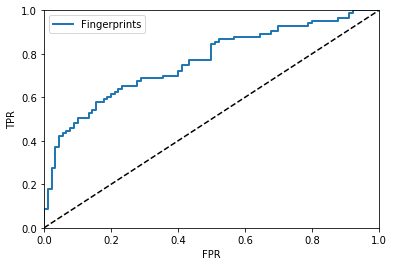

In [51]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(scores), np.std(scores)))
score = model.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(Y_train, score)
plot_roc_curve([fpr], [tpr], "Neural Net", ["Fingerprints"])

In [74]:
probs = model.predict_proba(X_test)
predictions = np.zeros(probs.shape, dtype=int)
predictions[probs > 0.5] = 1
targets = Y_test.values.reshape(Y_test.shape[0], 1)
print("Accuracy: ", accuracy_score(targets, predictions))
print("ROC AUC: ", roc_auc_score(targets, probs))

44/44 [==============================] - 0s 114us/step
Accuracy:  0.7727272727272727
ROC AUC:  0.8447204968944099
